In [1]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools

In [2]:
# import sys
# sys.path.append('/home/bcarry/Documents/softs/ocapy/gfx/')
# import figure_setup as fs

In [3]:
# To test new ssocards
# rocks.ssodnet.URL_SSODNET = 

# Get ZTF fit

In [4]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '../'


In [5]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [6]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])

fink_colors = ['#15284F', '#F5622E']

V_minus_g = -0.2833
V_minus_r = 0.1777

In [7]:
data = pd.read_parquet(f'{data_fink}data/ztf/sso_ZTF.parquet')

In [8]:
data['HG1G2hyb_dSpin'] = np.sqrt( (data['HG1G2hyb_dRA0']*np.cos(np.radians(data['HG1G2hyb_DEC0'])))**2 + data['HG1G2hyb_dDEC0']**2 )


# Remove solutions above 90 deg of latitude
cond = data.HG1G2hyb_DEC0 > 90
data.loc[cond,'HG1G2hyb_DEC0'] = 90
print(f'above 90: {len(data[cond])} ')

cond = data.HG1G2hyb_DEC0 < -90
data.loc[cond,'HG1G2hyb_DEC0'] = -90
print(f'below 90: {len(data[cond])} ')


above 90: 1 
below 90: 7 


In [9]:
# Spin coordinates: long/lat
# Define angle for astropy
ra = data.HG1G2hyb_RA0.values*u.degree
dec = data.HG1G2hyb_DEC0.values*u.degree

# Convert to EC and store in the pandas DataFrame
coords = SkyCoord(ra=ra, dec=dec, distance=200*u.parsec, frame='hcrs')
data['lon'] = coords.heliocentricmeanecliptic.lon.value
data['lat'] = coords.heliocentricmeanecliptic.lat.value

In [10]:
bft = pd.read_parquet(bft_file)

In [11]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ]        

In [12]:
data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )

In [13]:
data

,ssnamenr,nmeasurements,ndays,params,number,name,HG_H_g,HG_dH_g,HG_G_g,HG_dG_g,...,spins.3.DEC0.value,spins.3.long.value,spins.3.lat.value,spins.3.technique,spins.4.obliquity,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.technique
0,95367,82,1037.766238,"{'G_1': 0.06303630024194717, 'G_2': 0.19601918...",95367,2002 CS157,15.205434,0.049852,6.303630e-02,0.065679,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1,250264,64,219.697303,"{'G_1': 0.22324514389038086, 'G_2': 0.31732639...",250264,2003 CV12,16.374287,0.171846,2.232451e-01,0.148994,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
2,26487,208,1101.873183,"{'G_1': 0.33757442235946655, 'G_2': 0.33143043...",26487,2000 AV236,14.556883,0.039258,3.375744e-01,0.040907,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
3,189809,63,1002.917616,"{'G_1': 2.0782619075841241e-16, 'G_2': 0.08747...",189809,2002 LO19,15.083442,0.085618,2.078262e-16,0.089987,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
4,34395,116,1087.781169,"{'G_1': 0.5242671966552734, 'G_2': 0.381103187...",34395,2000 RS73,15.081876,0.147779,5.242672e-01,0.206629,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115142,20866,216,1061.878310,"{'G_1': 0.25884151458740234, 'G_2': 0.40618246...",20866,2000 VP37,13.469830,0.094156,2.588415e-01,0.089800,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
115143,39790,96,1016.752407,"{'G_1': 0.08864176273345947, 'G_2': 0.03623726...",39790,1997 PF,13.892776,0.040307,8.864176e-02,0.039136,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
115144,99263,65,794.646273,"{'G_1': 1.0, 'G_2': 0.8298622369766235, 'H_1':...",99263,2001 OZ31,17.481823,0.220211,1.000000e+00,0.380656,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
115145,18754,228,1181.814294,"{'G_1': 0.19368864595890045, 'G_2': 0.32351323...",18754,1999 GL21,14.145675,0.052304,1.936886e-01,0.048243,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None


In [14]:
thres = 1e-3

# HG Parameeter
maskG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
maskG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
maskG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
maskG = maskG_g & maskG_r & maskG_fit

# HG1G2 parameters
maskG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
maskG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
maskG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
maskG1G2 = maskG1G2_fit & maskG1G2_g & maskG1G2_r

# Hybrid ZTF
maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & ((1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g)>thres)
maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & ((1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r)>thres)
maskG1G2hyb_ZTF = maskG1G2hyb_g & maskG1G2hyb_r
maskG1G2hyb_fit = (data.HG1G2hyb_fit==0)  & (data.HG1G2hyb_status>=2)
maskG1G2hyb = maskG1G2hyb_fit & maskG1G2hyb_ZTF 



# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.HG1G2hyb_RA0>thres) & ( np.abs(360-data.HG1G2hyb_RA0)>thres )  & \
           ( np.abs(data.HG1G2hyb_RA0-180)>thres) & ( np.abs(data.HG1G2hyb_DEC0)>thres ) 

# Phase coverage
maskPhase = data.minphase<=3

# Global mask
mask = maskG1G2 & maskG1G2hyb
maskFINK = maskG1G2hyb & maskSpin & maskPhase

print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask G g      : {len(data[maskG_g]):6d}  ({100.*len(data[maskG_g])/len(data):>6.2f}%)')
print(f'  Mask G r      : {len(data[maskG_r]):6d}  ({100.*len(data[maskG_r])/len(data):>6.2f}%)')
print(f'  Mask G g+r    : {len(data[maskG]):6d}  ({100.*len(data[maskG])/len(data):>6.2f}%)')
print()
print(f'  Mask G1G2 g   : {len(data[maskG1G2_g]):6d}  ({100.*len(data[maskG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask G1G2 r   : {len(data[maskG1G2_r]):6d}  ({100.*len(data[maskG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask G1G2 g+r : {len(data[maskG1G2]):6d}  ({100.*len(data[maskG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask hyb g    : {len(data[maskG1G2hyb_g]):6d}  ({100.*len(data[maskG1G2hyb_g])/len(data):>6.2f}%)')
print(f'  Mask hyb r    : {len(data[maskG1G2hyb_r]):6d}  ({100.*len(data[maskG1G2hyb_r])/len(data):>6.2f}%)')
print(f'  Mask hyb g+r  : {len(data[maskG1G2hyb]):6d}  ({100.*len(data[maskG1G2hyb])/len(data):>6.2f}%)')
print()
print(f'  Mask Spin     : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask FINK     : {len(data[maskFINK]):6d}  ({100.*len(data[maskFINK])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)   : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for minphase in [2,3,4,5]:
    maskPhase = data.minphase<minphase
    print(f'  Mask phase {minphase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')


# len(data), len(data[mask]), len(data[maskG1G2]), len(data[maskG1G2sp]), len(data[maskG1G2hyb_g]), len(data[maskG1G2hyb_r]), len(data[maskG1G2hyb])

 All data       : 115147  (100.00%)

  Mask G g      : 114904  ( 99.79%)
  Mask G r      : 114906  ( 99.79%)
  Mask G g+r    : 112564  ( 97.76%)

  Mask G1G2 g   :  56815  ( 49.34%)
  Mask G1G2 r   :  62043  ( 53.88%)
  Mask G1G2 g+r :  40727  ( 35.37%)

  Mask hyb g    :  67796  ( 58.88%)
  Mask hyb r    :  72814  ( 63.24%)
  Mask hyb g+r  :  52393  ( 45.50%)

  Mask Spin     : 111977  ( 97.25%)

  Mask FINK     :  42274  ( 36.71%)

  Mask (both)   :  34525  ( 29.98%)
  Mask phase 2  :  57515  ( 49.95%)
  Mask phase 3  :  79455  ( 69.00%)
  Mask phase 4  :  93564  ( 81.26%)
  Mask phase 5  : 101933  ( 88.52%)


In [15]:


# # G1G2 mask for HG1G2, HG1G2spin, and hybrid model
# maskG1G2 = (data.HG1G2_G1>thres)  & (data.HG1G2_G2>thres) & (1-data.HG1G2_G1-data.HG1G2_G2>thres)
# maskG1G2sp = (data.HG1G2sp_G1>thres)  & (data.HG1G2sp_G2>thres) & (1-data.HG1G2sp_G1-data.HG1G2sp_G2>thres)
# maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & (1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g>thres)
# maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & (1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r>thres)
# maskG1G2hyb = maskG1G2hyb_g * maskG1G2hyb_r

# # G1G2 parameters likely to be wrong due to poor phase coverage
# maskPhase = data.minphase<min_phase

# # Spin solution suspicous: RA=={0,180,360}, DEC==0
# maskSpin = (data.HG1G2hyb_RA0>thres) & ( np.abs(360-data.HG1G2hyb_RA0)>thres )  & \
#            ( np.abs(data.HG1G2hyb_RA0-180)>thres) & ( np.abs(data.HG1G2hyb_DEC0)>thres ) 

# # Mask on Fit status
# maskFit = (data['HG1G2hyb_fit']==0) & ( (data['HG1G2hyb_status']==2) | (data['HG1G2hyb_status']==4) )

# # General sample for tests
# mask = maskG1G2 & maskG1G2sp & maskG1G2hyb & maskPhase & maskSpin

# # Sample to be published
# maskFINK = maskG1G2hyb & maskSpin & maskFit

# print(' All data       :', len(data))
# print('  Mask FINK     :', len(data[maskFINK]))
# print('  Mask hyb      :', len(data[maskG1G2hyb]))
# print('  Mask hyb g    :', len(data[maskG1G2hyb_g]))
# print('  Mask hyb r    :', len(data[maskG1G2hyb_r]))
# print('  Mask phase    :', len(data[maskPhase]))
# print('  Mask Spin     :',len(data[maskSpin]))
# print('  Mask          :', len(data[mask]))
# print()
# print('  Mask G1G2     :', len(data[maskG1G2]))
# print('  Mask g1g2spin :', len(data[maskG1G2sp]))


# Abs mag

In [16]:
# data['absolute_magnitude.value']

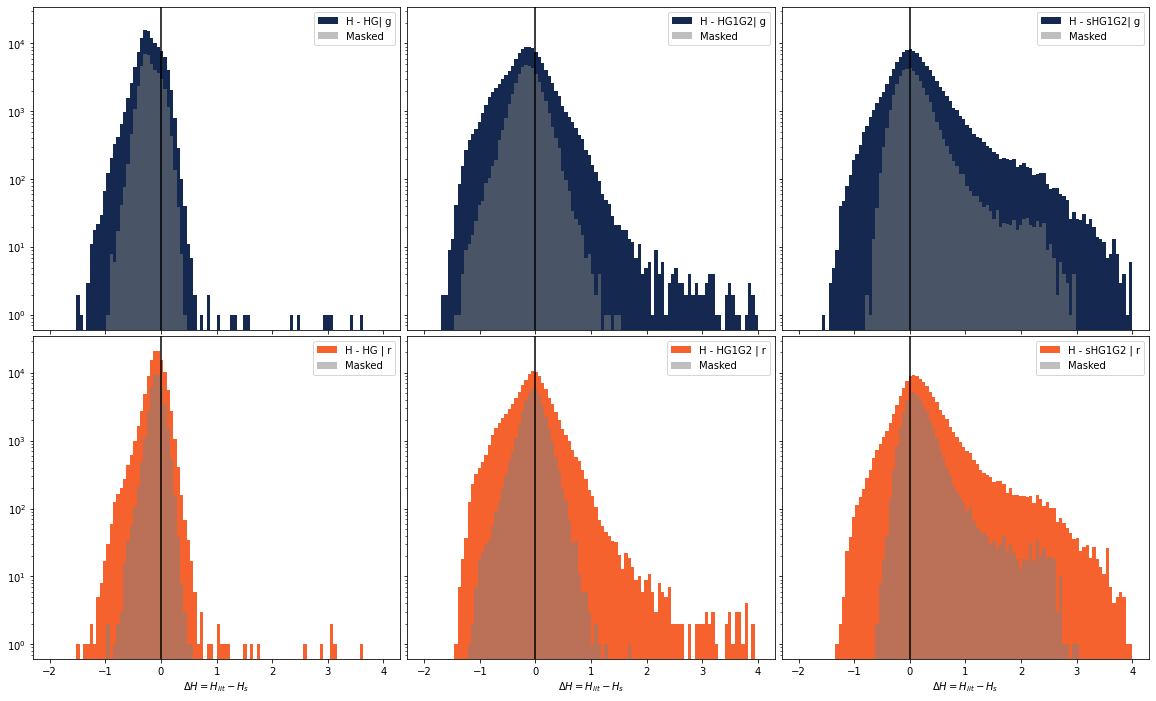

In [17]:
# Different colors
fig, ax = plt.subplots(2, 3, figsize=(20,12), sharex=True, sharey=True, gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [-2,4]
b = 100


# HG
x = (data['absolute_magnitude.value'] - data.HG_H_g) - V_minus_g
ax[0,0].hist( x, range=r, bins=b, label='H - HG| g', color=fink_colors[0] )
ax[0,0].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.HG_H_r) - V_minus_r
ax[1,0].hist( x, range=r, bins=b, label='H - HG | r', color=fink_colors[1] )
ax[1,0].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )



# HG1G2
x = (data['absolute_magnitude.value'] - data.HG1G2_H_g) - V_minus_g
ax[0,1].hist( x, range=r, bins=b, label='H - HG1G2| g' , color=fink_colors[0] )
ax[0,1].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.HG1G2_H_r) - V_minus_r
ax[1,1].hist( x, range=r, bins=b, label='H - HG1G2 | r', color=fink_colors[1] )
ax[1,1].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )


# sHG1G2
x = (data['absolute_magnitude.value'] - data.HG1G2hyb_H_g) - V_minus_g
ax[0,2].hist( x, range=r, bins=b, label='H - sHG1G2| g', color=fink_colors[0] )
ax[0,2].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.HG1G2hyb_H_r) - V_minus_r
ax[1,2].hist( x, range=r, bins=b, label='H - sHG1G2 | r', color=fink_colors[1] )
ax[1,2].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )


for a in ax.ravel():
    a.set_xlabel('$\Delta H = H_{lit} - H_s$')
    a.legend(loc='upper right')
    a.set_yscale('log')
    a.axvline(0, color='black')

# for a in ax[:,1:].ravel():
#     a.set_yticklabels('')
    
    
fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'H.png'), facecolor='white')
# fig.savefig(f'{data_fink}/gfx_models/deltaH_spin_hyb_masks.png', facecolor='white')

# Spin distribution

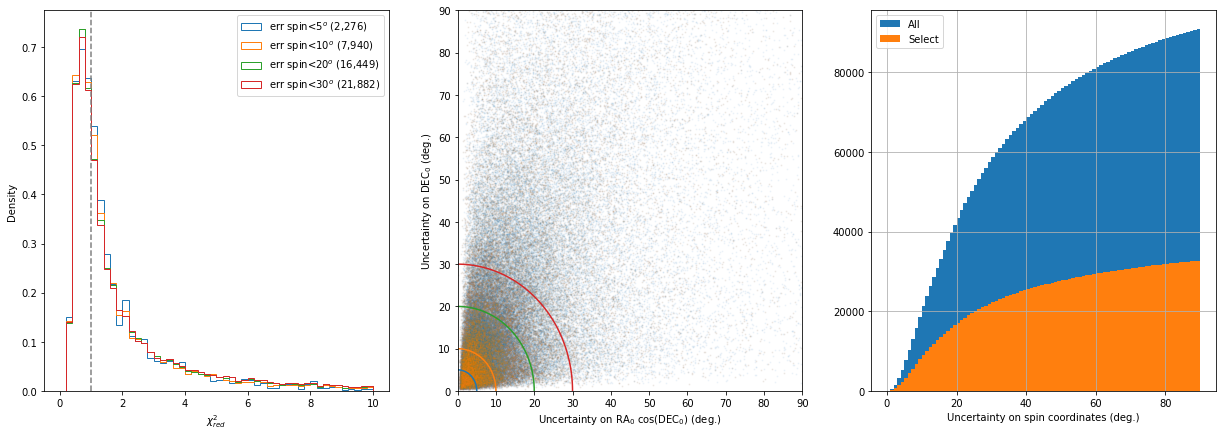

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


# Histogram of chi2
for err in [5,10,20,30]:
    cond = maskFINK
    cond = cond*(data.HG1G2hyb_dSpin<=err)
    ax[0].hist(data.loc[cond,'HG1G2hyb_chi2red'], bins=50, histtype='step', density=True, range=[0,10],
               label=f'err spin<{err:d}$^o$ ({len(data[cond]):,d})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter( data.HG1G2hyb_dRA0*np.cos(np.radians(data['HG1G2hyb_DEC0'])), data.HG1G2hyb_dDEC0, s=1, alpha=0.05 )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_dRA0']*np.cos(np.radians(data.loc[maskFINK,'HG1G2hyb_DEC0'])), data.loc[maskFINK,'HG1G2hyb_dDEC0'], s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

# Cumulative dSpin
r = [0,90]
b = 90
ax[2].hist( data.HG1G2hyb_dSpin, cumulative=True, density=False, range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'HG1G2hyb_dSpin'], cumulative=True, density=False, range=r, bins=b, label='Select' )

ax[2].grid()
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')
ax[2].legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)


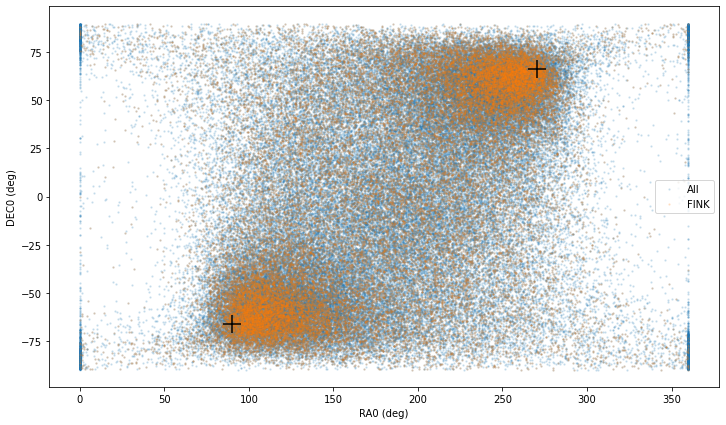

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

# All
cond = data.ssnamenr==data.ssnamenr
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15, label='All')

# FINK sample
cond = maskFINK
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15, label='FINK')


# Ecliptic poles
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )

coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
ax.legend()
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_bulk.png'), facecolor='white')


- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

Text(0.5, 0, 'DEC_0')

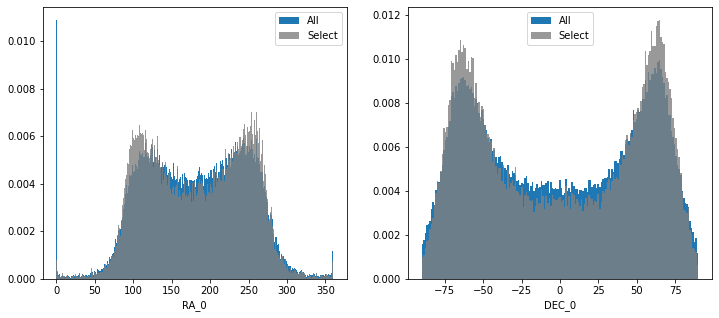

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist( data.HG1G2hyb_RA0, range=[0,360], bins=361, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'HG1G2hyb_RA0'], range=[0,360], bins=361, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend()
ax[0].set_xlabel('RA_0')

ax[1].hist( data.HG1G2hyb_DEC0, range=[-90,90], bins=181, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'HG1G2hyb_DEC0'], range=[-90,90], bins=181, density=True, label='Select', color='grey', alpha=0.8 )
ax[1].legend()
ax[1].set_xlabel('DEC_0')

In [21]:
# Flip half of the solution
cond = (data.index %2 ==0 )
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

data.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

# Convert (again) to EC
coords = SkyCoord(ra=data.loc[cond,xax]*u.deg, dec=data.loc[cond,yax]*u.deg, distance=200*u.parsec, frame='hcrs')
data.loc[cond,'lon'] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond,'lat'] = coords.heliocentricmeanecliptic.lat.value

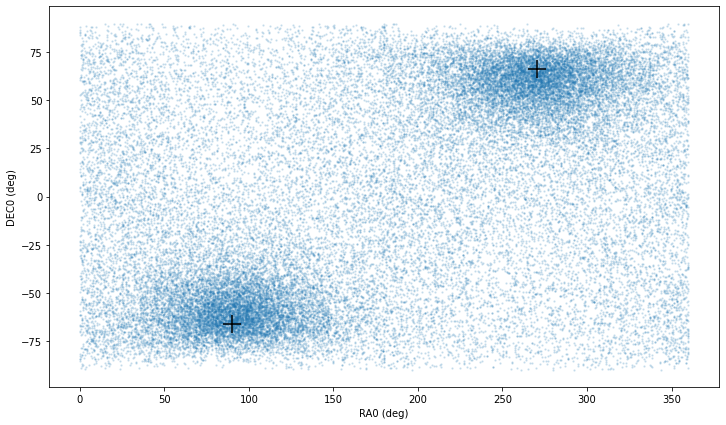

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))

cond = data.ssnamenr==data.ssnamenr
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

# ax.scatter( data.loc[cond,xax], 
#             data.loc[cond,yax], 
#             s=2, alpha=0.15)

# Sample FINK
ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
            s=2, alpha=0.15)

# Ecliptic poles
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_selected.png'), facecolor='white')


# Compare with literature

In [23]:
data['spins.1.technique'].value_counts()

LC        18285
LCI        2695
LC+TPM      570
TE           69
ADAM         43
LC-TPM       40
Radar        18
LC+Occ       17
A-M           5
SPACE         5
LC+IM         4
SAGE          4
Bin-IM        1
TE-Occ        1
Name: spins.1.technique, dtype: int64

In [24]:
# Compute angular distances
spin_version = np.array(['A','B'])

for ks in ['1','2','3','4']:
    data[f'spins.{ks}.distance'] = np.nan
    cond = (~data[f'spins.{ks}.RA0.value'].isna())
    
    #------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond,f'spins.{ks}.distance.A'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.A'] = (data.loc[cond,f'spins.{ks}.RA0.value']-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.A'] = (data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond,f'spins.{ks}.distance.B'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians( (x[0]+180) % 360 ), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.B'] = ( ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(-data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.B'] = (-data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.closest'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: int(np.argmin(x)), axis=1 )
    data = data.astype({f'spins.{ks}.closest':'Int64'})

    data.loc[cond,f'spins.{ks}.distance'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                            f'spins.{ks}.distance.B']].apply( lambda x: np.min(x), axis=1 )
    data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: spin_version[np.argmin(x)], axis=1 )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
                                                            f'spins.{ks}.delta_RA.B', 
                                                            f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.delta_DEC'] = data.loc[cond, [f'spins.{ks}.delta_DEC.A',
                                                             f'spins.{ks}.delta_DEC.B', 
                                                             f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )

    
# Select the closest angularly
cond = ~data[f'spins.1.distance'].isna()
data.loc[cond,'spins.closest'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: int(np.argmin(x)), axis=1 )
data = data.astype({'spins.closest':'Int64'})

data.loc[cond,'spins.distance'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: np.min(x), axis=1 )
data.loc[cond,'spins.delta_RA'] = data.loc[cond, [f'spins.1.delta_RA',
                                                  f'spins.2.delta_RA',
                                                  f'spins.3.delta_RA',
                                                  f'spins.4.delta_RA', 
                                                  f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.delta_DEC'] = data.loc[cond, [f'spins.1.delta_DEC',
                                                   f'spins.2.delta_DEC',
                                                   f'spins.3.delta_DEC',
                                                   f'spins.4.delta_DEC', 
                                                   f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )



(0.0, 90.0)

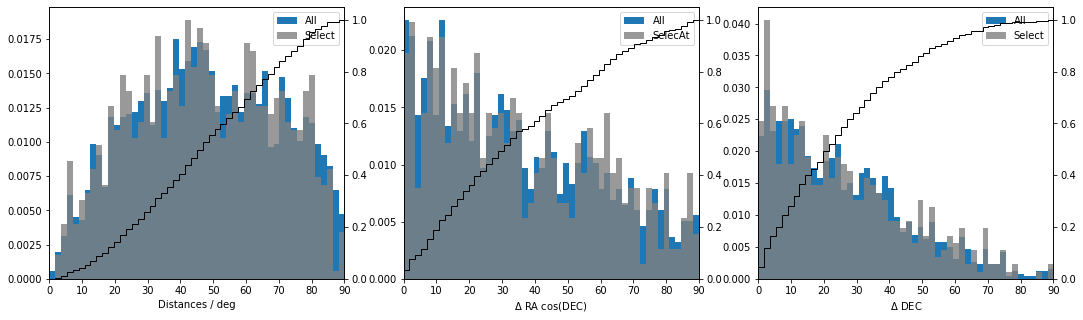

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

r = [0,90]
b = 50
ax[0].hist( data.loc[cond,'spins.distance'], range=r, bins=b, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend()
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[0].set_xlim(r)

ax[1].hist( data.loc[cond,'spins.delta_RA'], range=r, bins=b, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, label='SelecAt', color='grey', alpha=0.8 )
ax[1].legend()
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[1].set_xlim(r)

ax[2].hist( data.loc[cond,'spins.delta_DEC'], range=r, bins=b, density=True, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[2].legend()
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

# fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances.png'), facecolor='white')


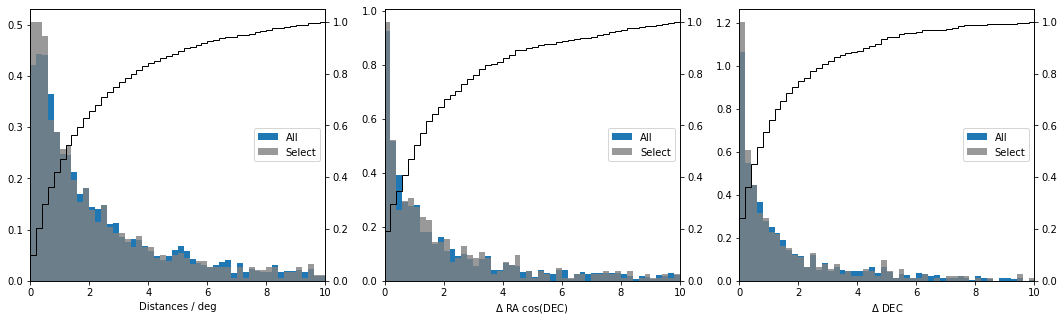

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


r = [0,10]
b = 50

x = data['spins.distance'] / data['HG1G2hyb_dSpin']
ax[0].hist( x, range=r, bins=b, density=True, label='All' )
ax[0].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend(loc='center right')
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[0].set_xlim(r)

x = data['spins.delta_RA'] / data['HG1G2hyb_dRA0']
ax[1].hist( x, range=r, bins=b, density=True, label='All' )
ax[1].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[1].legend(loc='center right')
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[1].set_xlim(r)

x = data['spins.delta_DEC'] / data['HG1G2hyb_dDEC0']
ax[2].hist( x, range=r, bins=b, density=True, label='All' )
ax[2].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[2].legend(loc='center right')
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_normed.png'), facecolor='white')

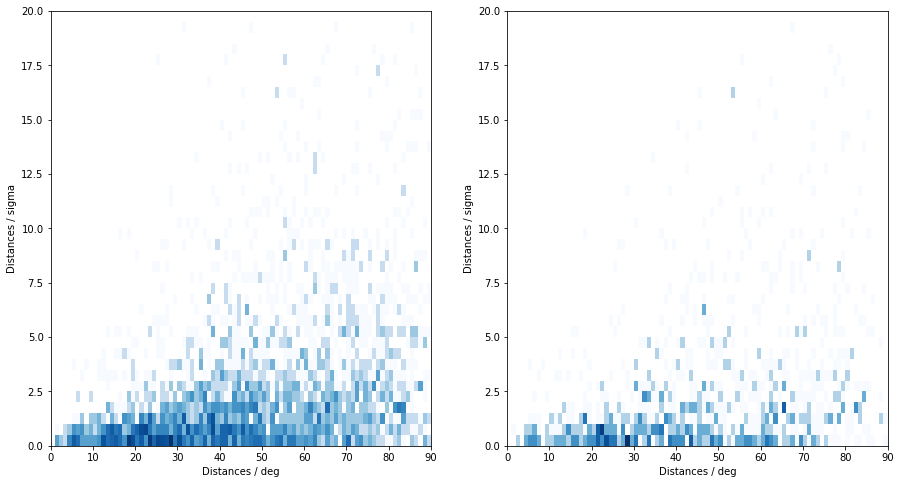

In [27]:
fig, ax = plt.subplots( 1, 2, figsize=(15,8))

r = [ [0,90],[0,20] ]
b = [90,40]

x = data['spins.distance'] 
y = data['spins.distance'] / data['HG1G2hyb_dSpin']
ax[0].hist2d( x, y, label='All', range=r, bins=b, cmap='Blues', norm='log', density=True )
ax[1].hist2d( x[maskFINK], y[maskFINK], label='Select', range=r, bins=b, cmap='Blues', norm='log', density=True)

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel('Distances / deg')
    a.set_ylabel('Distances / sigma')

fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_vs_sigma.png'), facecolor='white')

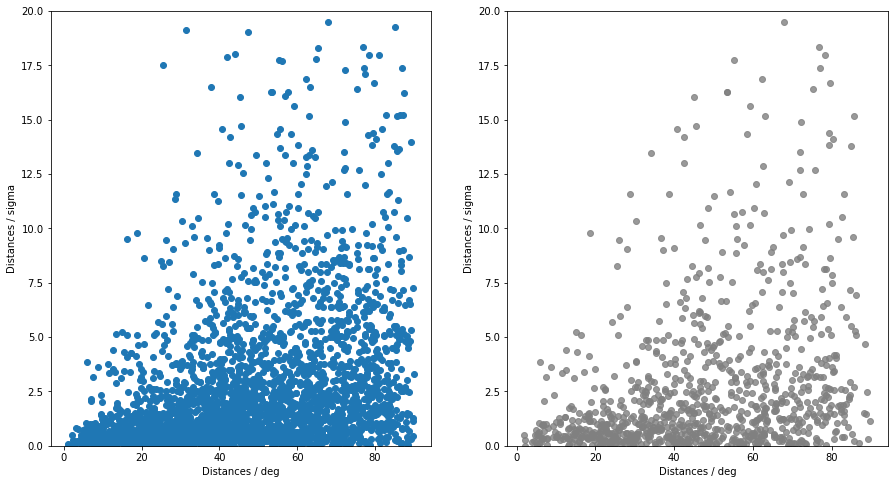

In [28]:
fig, ax = plt.subplots( 1, 2, figsize=(15,8))

r = [ [0,90],[0,20] ]
# b = [90,50]

x = data['spins.distance'] #/ data['HG1G2hyb_dSpin']
y = data['spins.distance'] / data['HG1G2hyb_dSpin']
ax[0].scatter( x, y, label='All' )
ax[1].scatter( x[maskFINK], y[maskFINK], label='Select', color='grey', alpha=0.8 )

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel('Distances / deg')
    a.set_ylabel('Distances / sigma')
    a.set_ylim(r[1])

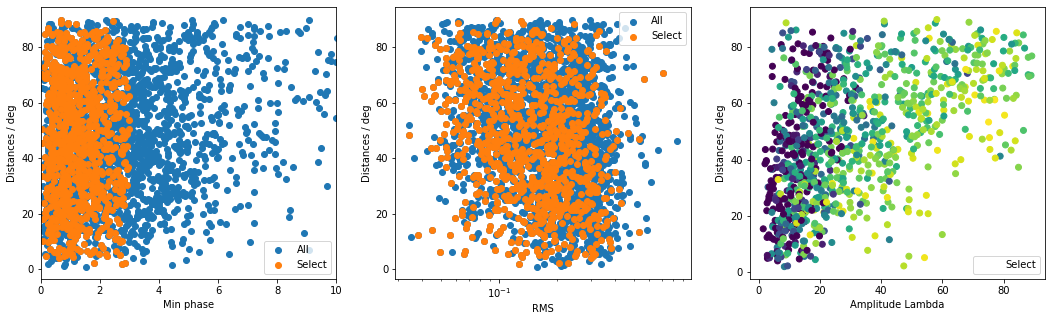

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

x = data['minphase']
y = data['spins.distance']
ax[0].scatter( x,y, label='All' )
ax[0].scatter( x[maskFINK], y[maskFINK], label='Select' )
ax[0].legend()
ax[0].set_xlabel('Min phase')
ax[0].set_ylabel('Distances / deg')
ax[0].set_xlim(0,10)

x = data['HG1G2hyb_rms']
y = data['spins.distance']
ax[1].scatter( x,y, label='All' )
ax[1].scatter( x[maskFINK], y[maskFINK], label='Select' )
ax[1].legend()
ax[1].set_xlabel('RMS')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

# x = np.degrees(np.arccos(data['HG1G2hyb_maxCosLambda'] - data['HG1G2hyb_minCosLambda']))
x = np.degrees(np.arccos(data['HG1G2hyb_minCosLambda']) - np.arccos(data['HG1G2hyb_maxCosLambda']))
y = data['spins.distance']
# ax[2].scatter( x, y, label='All' )
ax[2].scatter( x[maskFINK], y[maskFINK], c=data.loc[maskFINK,'HG1G2hyb_R'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('Amplitude Lambda')
# ax[2].set_yscale('log')
ax[2].set_ylabel('Distances / deg')

fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_vs_obs.png'), facecolor='white')

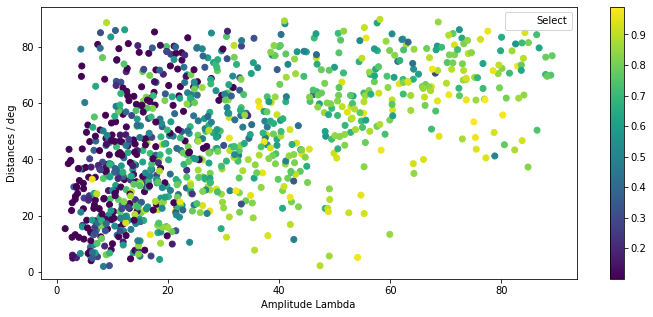

In [30]:
fig, ax = plt.subplots(figsize=(12,5))

x = np.degrees(np.arccos(data['HG1G2hyb_minCosLambda']) - np.arccos(data['HG1G2hyb_maxCosLambda']))
y = data['spins.distance']
im = ax.scatter( x[maskFINK], y[maskFINK], c=data.loc[maskFINK,'HG1G2hyb_R'], label='Select' )
ax.legend()
ax.set_xlabel('Amplitude Lambda')
ax.set_ylabel('Distances / deg')

fig.colorbar(im)

# fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_vs_obs.png'), facecolor='white')

(array([ 2436.,  1879.,  2169.,  2870.,  4243.,  5595.,  7592., 10267.,
        14374., 62981.]),
 array([-9.95982945e-01, -8.96384650e-01, -7.96786356e-01, -6.97188061e-01,
        -5.97589767e-01, -4.97991472e-01, -3.98393178e-01, -2.98794883e-01,
        -1.99196589e-01, -9.95982945e-02, -1.51307092e-12]),
 <BarContainer object of 10 artists>)

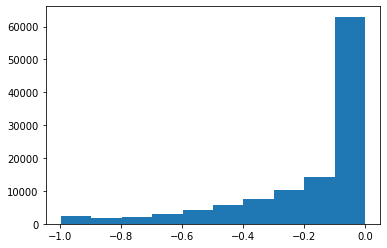

In [31]:
plt.hist( - data['HG1G2hyb_minCosLambda'])

In [32]:
data.columns[:80]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_status', 'HG_fit', 'HG_rms', 'HG_chi2red',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red', 'HG1G2_status', 'HG1G2_fit', 'HG1G2hyb_H_g',
       'HG1G2hyb_dH_g', 'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g',
       'HG1G2hyb_dG2_g', 'HG1G2hyb_rms_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r',
       'HG1G2hyb_G1_r', 'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r',
       'HG1G2hyb_rms_r', 'HG1G2hyb_RA0', 'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0',
       'HG1G2hyb_dDEC0', 'HG1G2hyb_R', 'HG1G2hyb_dR', 'HG1G2hyb_rms',
       'HG1G2hyb_chi2red', 'HG1

Text(0, 0.5, 'Distances / deg')

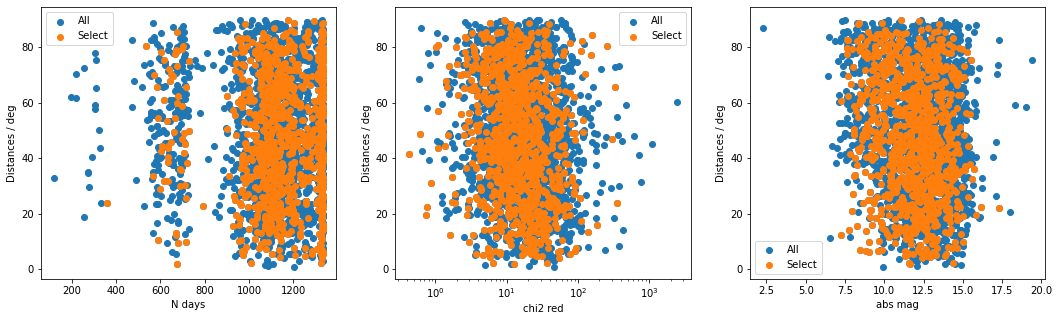

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'n_days'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'n_days'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('N days')
ax[0].set_ylabel('Distances / deg')

ax[1].scatter( data.loc[cond,'HG1G2hyb_chi2red'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_chi2red'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('chi2 red')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

ax[2].scatter( data.loc[cond,'absolute_magnitude.value'], data.loc[cond,'spins.distance'], label='All' )
ax[2].scatter( data.loc[maskFINK,'absolute_magnitude.value'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('abs mag')
# ax[2].set_xscale('log')
ax[2].set_ylabel('Distances / deg')


(42274, 2834)

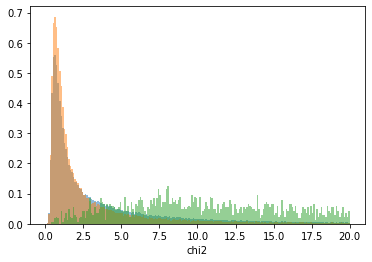

In [34]:
r = [0,20]
b = 200 
plt.hist(data['HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

(42274, 2834)

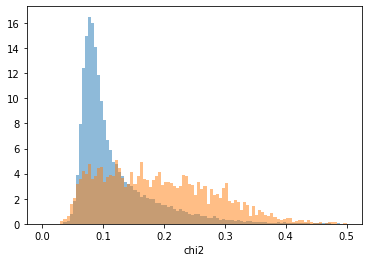

In [35]:
r = [0,0.5]
b = 100 
# plt.hist(data['HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

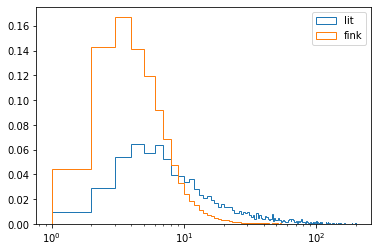

In [36]:
fig, ax = plt.subplots()

ax.hist( data.loc[cond,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='lit')
ax.hist( data.loc[maskFINK,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='fink' )

ax.set_xscale('log')
ax.legend()

In [37]:
cond = maskFINK
lim_spin = 30
spin_v = '1'
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
data.loc[cond,f'spins.{spin_v}.technique'].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

LCI       135
LC+TPM     34
LC          7
LC-TPM      5
LC+Occ      3
ADAM        2
TE          2
Radar       1
Name: spins.1.technique, dtype: int64

In [38]:
cond = maskFINK
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
cond = cond * (data[f'spins.{spin_v}.technique']=='Radar')

cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number')
# data.loc[cond,'spins.1.technique'].value_counts()

,number,name,HG1G2hyb_RA0,HG1G2hyb_DEC0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
51545,3908,Nyx,223.016987,78.894511,324.095112,72.90479,A,NaN,NaN,NaN,22.022069,NaN


In [39]:
cond = maskFINK
data[cond].sort_values(by='sso_number').head(20)

,ssnamenr,nmeasurements,ndays,params,number,name,HG_H_g,HG_dH_g,HG_G_g,HG_dG_g,...,spins.4.delta_RA.B,spins.4.delta_DEC.B,spins.4.closest,spins.4.version,spins.4.delta_RA,spins.4.delta_DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC
46631,24,82,1125.539445,"{'G_1': 0.10325620323419571, 'G_2': 0.07803010...",24,Themis,7.272201,0.020437,0.103256,0.020498,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,12.370779,-12.690628,4.825571
83066,33,241,1306.151319,"{'G_1': 0.2963821589946747, 'G_2': 0.314341187...",33,Polyhymnia,8.863579,0.019312,0.296382,0.022105,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,44.088590,52.944771,-28.163797
46683,34,245,1318.245718,"{'G_1': 0.07025325298309326, 'G_2': 0.11341873...",34,Circe,8.794043,0.154720,0.070253,0.120156,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,24.082331,5.479695,-23.625002
34949,38,101,1185.626690,"{'G_1': 0.2305288016796112, 'G_2': 0.251248270...",38,Leda,8.798278,0.039817,0.230529,0.041699,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,66.648913,65.427657,10.106814
78757,46,132,1240.665000,"{'G_1': 0.06789280474185944, 'G_2': 0.21250496...",46,Hestia,8.594395,0.142653,0.067893,0.110163,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,80.473494,-48.930973,70.784011
104242,47,137,1330.100127,"{'G_1': 0.21683651208877563, 'G_2': 0.29061520...",47,Aglaja,8.313188,0.040078,0.216837,0.041732,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,57.097278,99.113434,-28.426510
835,49,200,1089.777789,"{'G_1': 0.04535161703824997, 'G_2': 0.09985937...",49,Pales,7.882965,0.031231,0.045352,0.022373,...,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
62856,58,141,1182.660868,"{'G_1': 0.07451643794775009, 'G_2': 0.10732368...",58,Concordia,9.048164,0.012848,0.074516,0.010953,...,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
105603,62,220,1079.833530,"{'G_1': 0.26122546195983887, 'G_2': 0.27954643...",62,Erato,9.110784,0.073983,0.261225,0.074488,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,63.191608,45.351398,-49.891959
29403,73,198,1086.856562,"{'G_1': 0.10386741161346436, 'G_2': 0.32310897...",73,Klytia,9.294371,0.085685,0.103867,0.064533,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,9.708625,7.337528,-7.399204


In [40]:
cond = maskFINK
cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number').head(20)

,number,name,HG1G2hyb_RA0,HG1G2hyb_DEC0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
46631,24,Themis,95.627081,-69.338571,246.135000,64.513000,B,NaN,NaN,NaN,12.370779,NaN
83066,33,Polyhymnia,140.814395,71.373797,157.258000,-49.633000,B,33.456,-43.210,B,58.425905,44.088590
46683,34,Circe,267.364422,51.247002,273.549000,27.622000,A,96.252,58.352,A,24.082331,70.160978
34949,38,Leda,269.078034,-2.166814,155.139000,-7.940000,B,346.679,-12.214,A,66.648913,77.425581
78757,46,Hestia,160.233123,-61.841011,112.808000,28.869000,B,290.700,-8.943,B,81.601138,80.473494
104242,47,Aglaja,13.006365,74.362510,155.521000,45.936000,A,317.916,-3.910,A,57.097278,84.937950
835,49,Pales,171.353696,-35.558381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62856,58,Concordia,287.422961,-40.650089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105603,62,Erato,223.726289,49.455959,269.079000,-0.436000,A,86.037,45.398,A,63.191608,78.257356
29403,73,Klytia,257.829041,70.663204,274.139000,63.264000,A,NaN,NaN,NaN,9.708625,NaN


In [41]:
data.columns[:80]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_status', 'HG_fit', 'HG_rms', 'HG_chi2red',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red', 'HG1G2_status', 'HG1G2_fit', 'HG1G2hyb_H_g',
       'HG1G2hyb_dH_g', 'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g',
       'HG1G2hyb_dG2_g', 'HG1G2hyb_rms_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r',
       'HG1G2hyb_G1_r', 'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r',
       'HG1G2hyb_rms_r', 'HG1G2hyb_RA0', 'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0',
       'HG1G2hyb_dDEC0', 'HG1G2hyb_R', 'HG1G2hyb_dR', 'HG1G2hyb_rms',
       'HG1G2hyb_chi2red', 'HG1

# Obliquity

In [42]:
# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)


In [43]:
fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

cond = data.ssnamenr==data.ssnamenr
cond = maskFINK
ax.scatter( data.loc[cond,'diameter.value'],
            data.loc[cond,'obliquity'], 
            marker='.',
            color=colors[0], 
            s=2, 
            alpha=0.15 )

ax.set_xscale('log')
ax.set_xlim(1,300)
ax.set_ylim(0,180)
ax.set_xlabel('Diameter / km')
ax.set_ylabel('Obliquity / deg')


ax.set_xticks([1,10,100])
ax.set_xticklabels(['1','10','100'])
ax.set_yticks([0,30,60,90,120,150,180])

fig.savefig(f'{data_fink}plots/obliquity_vs_diameter.png', facecolor='white', dpi=150)


NameError: name 'fs' is not defined

In [ ]:
cond = maskFINK & (data['diameter.value']<10)
fig, ax = plt.subplots()

r = [0,180]
b = 37
ax.hist( data.loc[cond,'obliquity'], bins=b, range=r )

# Oblateness

In [ ]:
damit = pd.read_csv( f'{data_fink}/data/damit.csv' )

In [ ]:
np.mean(damit.R), np.mean(damit.R2)

In [ ]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
fig, ax = plt.subplots(figsize=(10,6), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']


ax.hist( damit.R, range=r, bins=b, 
        color='lightgray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )

ax.hist( damit.R2, range=r, bins=b, 
        color='slategray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )
# ax.hist( data.loc[maskFINK,'HG1G2hyb_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.HG1G2hyb_dR<0.9) & maskFINK
ax.hist( data.loc[cond,'HG1G2hyb_R'], range=r, bins=b, 
         color=colors[0], 
        density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

ax.set_ylim(0,4)
ax.set_xlabel('Oblateness R')
ax.set_ylabel('Count density')
ax.legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


In [ ]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
fig, ax = plt.subplots(1, 2, figsize=(12,5), 
                       gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']

x = damit.merge(data, left_on='number', right_on='sso_number')

# ax.scatter( x.R, x.HG1G2hyb_R ) 
ax[0].hist2d( x.R, x.HG1G2hyb_R, range=[[0.3,1],[0.3,1]], bins=14) 
xx = np.linspace(0.3,1,num=10)
ax[1].plot(xx,xx, color='white')

ax[1].hist( (x.R-x.HG1G2hyb_R)/x.HG1G2hyb_dR, range=[-5,5], bins=20sso_fink_SHG1G2_sign.parquet )



# ax.set_ylim(0,4)
ax[0].set_xlabel('FINK R')
ax[0].set_ylabel('Count density')

ax[0].set_xlabel('(FINK R - DAMIT R) / dR')

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


In [ ]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.HG1G2hyb_R>0.18)
data[cond].sort_values(by='HG1G2hyb_R').head(40)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

r = [0,1]
b = 50


cond = maskFINK

ax[0].scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[1].scatter( data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[2].scatter( data.loc[cond,'HG1G2hyb_G1_r']+data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )

ax[0].set_xlabel('G1')
ax[1].set_xlabel('G2')
ax[2].set_xlabel('G1 + G2')
ax[0].set_ylabel('R')

# ax.legend(loc='upper left')

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

r = [0,1]
b = 50

cond = data['HG1G2hyb_R']<0.2

ax.scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_G2_r'], marker='.', alpha=0.15 )

# ax[0].set_xlabel('G1')
# ax[1].set_xlabel('G2')
# ax[2].set_xlabel('G1 + G2')
# ax[0].set_ylabel('R')

# ax.legend(loc='upper left')